# Job Search VII: A McCall Worker Q-Learns

## Overview

This lecture illustrates a powerful machine learning technique called Q-learning.

{cite}`Sutton_2018` presents Q-learning and a variety of other statistical learning procedures.

The Q-learning algorithm combines ideas from

* dynamic programming

* a recursive version of least squares known as [temporal difference learning](https://en.wikipedia.org/wiki/Temporal_difference_learning).

This lecture applies a Q-learning algorithm to the situation faced by  a   McCall worker.

This lecture also considers the case where a McCall worker is given an option to quit the current job.


Relative to the dynamic programming formulation of the McCall worker model that we studied in  {doc}`quantecon lecture <mccall_model>`, a Q-learning algorithm gives the worker less knowledge about

* the random process that generates a sequence of wages
* the reward function that tells  consequences of accepting or rejecting a job

The Q-learning algorithm  invokes a statistical learning model to learn about these things.

Statistical learning often comes down to some version of least squares, and it will be here too.

Any time we say **statistical learning**, we have to say what object is being learned.

For Q-learning, the object that is learned is not  the **value function** that is a focus
of dynamic programming.

But it is something that is closely affiliated with it.

In the finite-action, finite state context studied in this lecture, the object to be learned statistically is a **Q-table**, an instance of a **Q-function** for finite sets.

Sometimes a Q-function or Q-table is called  a quality-function or quality-table.

The rows and columns of a Q-table correspond to possible states that an agent might encounter, and possible
actions that he can take in each state.

An equation  that resembles a  Bellman equation  plays an important role in the algorithm.

It  differs from the Bellman equation for the McCall model that we have seen in {doc}`this quantecon lecture <mccall_model>`

In this lecture, we'll learn a little about

* the **Q-function** or **quality function** that is affiliated with any Markov decision problem whose optimal value function satisfies a Bellman equation

* **temporal difference learning**,  a key component of a Q-learning algorithm

As usual, let's  import some Python modules.

In [1]:
!pip install quantecon

In [2]:
import numpy as np

from numba import jit, float64, int64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

import matplotlib.pyplot as plt

np.random.seed(123)

## Review of McCall Model

We begin by reviewing the McCall model described in {doc}`this quantecon lecture <mccall_model>`.

We'll  compute an optimal value function and a policy that attains it.

We'll eventually compare that optimal policy to what the Q-learning McCall worker learns.


The McCall model is characterized by parameters $\beta,c$ and a known distribution of wage offers $F$.



A McCall worker wants to maximize an expected discounted sum of lifetime incomes

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

The worker's income $y_t$ equals his wage $w$ if he is employed, and unemployment compensation $c$ if he is unemployed.


An optimal value  $V\left(w\right) $ for a McCall worker who has just received a wage offer $w$ and is deciding whether
to accept or reject it satisfies the Bellman equation

$$
V\left(w\right)=\max_{\text{accept, reject}}\;\left\{ \frac{w}{1-\beta},c+\beta\int V\left(w'\right)dF\left(w'\right)\right\}
$$ (eq_mccallbellman)

To form a benchmark to compare with results from Q-learning, we  first approximate the optimal value function.

With possible states residing in a finite discrete state space indexed by $\{1,2,...,n\}$, we make an initial guess for the value function of $v\in\mathbb{R}^{n}$ and then iterate on the Bellman equation:

$$
v^{\prime}(i)=\max \left\{\frac{w(i)}{1-\beta}, c+\beta \sum_{1 \leq j \leq n} v(j) q(j)\right\} \quad \text { for } i=1, \ldots, n
$$

Let's use  Python   code from {doc}`this quantecon lecture <mccall_model>`.

We use a Python method called `VFI` to compute the optimal value function using value function iterations.

We construct an assumed distribution  of wages and plot it with the following Python code

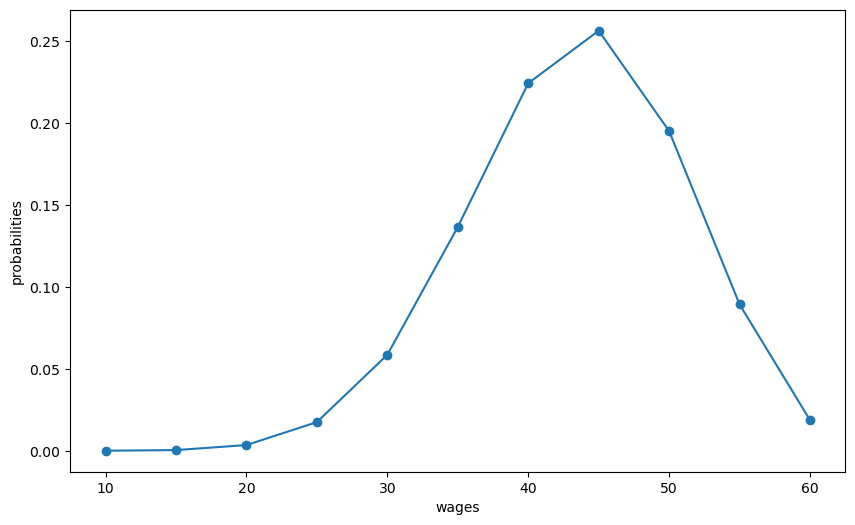

In [3]:
n, a, b = 10, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

# plot distribution of wage offer
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

Next we'll compute the worker's optimal value function by iterating to convergence on the Bellman equation.

Then we'll plot various iterates on the Bellman operator.

In [4]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:]),    # array of probabilities
]


@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w, q

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

    def VFI(self, eps=1e-5, max_iter=500):
        """
        Find the optimal value function.
        """

        n = len(self.w)
        v = self.w / (1 - self.β)
        v_next = np.empty_like(v)
        flag=0

        for i in range(max_iter):
            for j in range(n):
                v_next[j] = np.max(self.state_action_values(j, v))

            if np.max(np.abs(v_next - v))<=eps:
                flag=1
                break
            v[:] = v_next

        return v, flag

def plot_value_function_seq(mcm, ax, num_plots=8):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

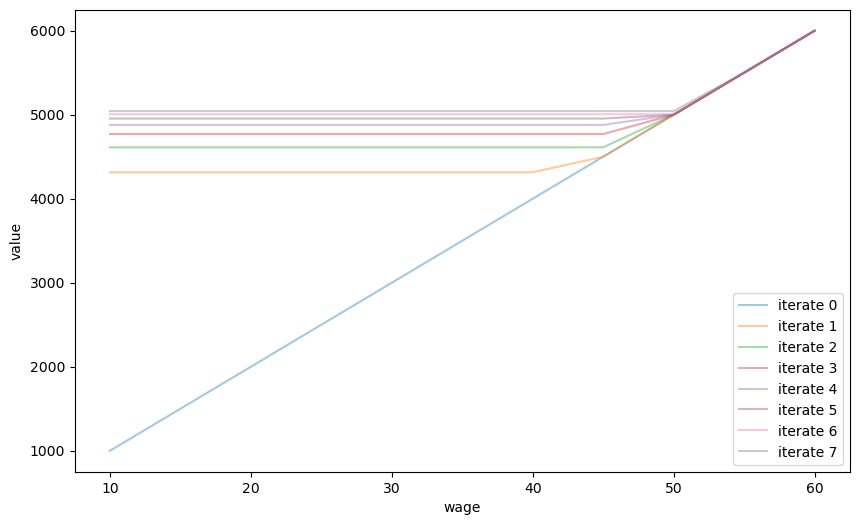

In [5]:
mcm = McCallModel()
valfunc_VFI, flag = mcm.VFI()

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

Next we'll print out the limit of the sequence of iterates.

This  is the approximation to the McCall worker's value function that is produced by value function iteration.

We'll use this value function as a benchmark later after we have done some Q-learning.

In [6]:
print(valfunc_VFI)

[5322.27935875 5322.27935875 5322.27935875 5322.27935875 5322.27935875
 5322.27935875 5322.27935875 5322.27935875 5322.27935875 5500.
 6000.        ]


## Implied Quality Function  $Q$


A **quality function** $Q$ map  state-action pairs into optimal values.

They are tightly linked to optimal  value functions.

But value functions  are functions just of states, and not actions.

For each given  state, the quality function gives a list of optimal values that can be attained starting from that
state, with each component of the list indicating one of the possible actions that is taken.



For our McCall worker with a finite set of possible wages

* the state space  $\mathcal{W}=\{w_1,w_2,...,w_n\}$ is indexed by integers $1,2,...,n$

* the action space is  $\mathcal{A}=\{\text{accept}, \text{reject}\}$

Let $a \in \mathcal{A}$ be one of the  two possible actions, i.e., accept or reject.

For our McCall worker, an optimal Q-function $Q(w,a)$ equals the maximum value of that a  previously unemployed   worker who has offer $w$ in hand can attain if he takes action $a$.

This definition of $Q(w,a)$ presumes that in subsequent periods the worker  takes  optimal actions.

An optimal   Q-function for our McCall worker satisfies

$$
\begin{aligned}
Q\left(w,\text{accept}\right) & =\frac{w}{1-\beta} \\
Q\left(w,\text{reject}\right) & =c+\beta\int\max_{\text{accept, reject}}\left\{ \frac{w'}{1-\beta},Q\left(w',\text{reject}\right)\right\} dF\left(w'\right)
\end{aligned}
$$ (eq:impliedq)


Note that the first equation of system {eq}`eq:impliedq` presumes that after  the agent has  accepted an offer, he will not have the objection to reject that same offer in the future.

These equations are aligned with the Bellman equation for the worker's  optimal value function that we studied in {doc}`this quantecon lecture <mccall_model>`.



Evidently, the optimal value function $V(w)$ described in that lecture is related to our Q-function by

$$
V(w) = \max_{\textrm{accept},\textrm{reject}} \left\{ Q(w, \text{accept} \right), Q\left(w,\text{reject} \right)\}
$$

If we stare at the second equation of system {eq}`eq:impliedq`, we notice that since the wage process is identically and independently distributed over time,
 $Q\left(w,\text{reject}\right)$, the right side of the equation is independent of the current state   $w$.

So we can denote it as a scalar

$$ Q_r := Q\left(w,\text{reject}\right) \quad \forall \, w\in\mathcal{W}.
$$

This fact provides us with an
an alternative, and  as it turns out in this case, a faster way to compute an optimal value function and associated optimal policy for the McCall worker.

Instead of using the  value function iterations that we deployed above, we can instead  iterate to convergence on a version of the second equation in system {eq}`eq:impliedq`  that maps an estimate of  $Q_r$ into an improved estimate $Q_r'$:

$$
Q_{r}^\prime=c+\beta\int\max_{\text{}}\left\{ \frac{w'}{1-\beta},Q_{r}\right\} dF\left(w'\right)
$$

After a $Q_r$ sequence has converged, we can recover the optimal value function $V(w)$ for the McCall worker from


$$
V\left(w\right)=\max\left\{ \frac{w}{1-\beta},Q_{r}\right\}
$$

## From Probabilities  to Samples

We noted  above that  the optimal Q function for our McCall worker satisfies the Bellman equations

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ Q (w, \textrm{accept}), Q(w, \textrm{reject}) \right\} - Q (w, \textrm{accept})   = 0  \cr
         c  & +\beta\int\max_{\text{accept, reject}}\left\{ Q(w', \textrm{accept}),Q\left(w',\text{reject}\right)\right\} dF\left(w'\right) - Q\left(w,\text{reject}\right)  = 0  \cr
\end{aligned}
$$ (eq:probtosample1)

Notice the integral over $F(w')$ on the second line.

Erasing the integral sign sets the stage for an illegitmate argument that can get us started thinking about  Q-learning.

Thus, construct a difference  equation system that keeps the first equation of {eq}`eq:probtosample1`
but replaces the second by removing integration over $F (w')$:

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ Q (w, \textrm{accept}), Q(w, \textrm{reject}) \right\} - Q (w, \textrm{accept})   = 0  \cr
         c  & +\beta \max_{\text{accept, reject}}\left\{ Q(w', \textrm{accept}),Q\left(w',\text{reject}\right)\right\}  - Q\left(w,\text{reject}\right)  \approx 0  \cr
\end{aligned}
$$(eq:probtosample2)


The second equation can't  hold for all $w, w'$ pairs in the appropriate Cartesian product of our  state space.

But maybe an appeal to  a   Law of Large numbers could let  us  hope that it would hold
**on average** for a long time series sequence of draws of $w_t, w_{t+1}$ pairs, where
we are thinking of $w_t$ as $w$ and $w_{t+1}$ as $w'$.

The basic idea of Q-learning is to draw a long sample of wage offers from $F$ (we know $F$ though we assume that the worker doesn't) and iterate on a  recursion
that maps an estimate $\hat Q_t$ of a  Q-function at date $t$ into an improved estimate
$\hat Q_{t+1}$ at date
$t+1$.

To set up such an algorithm, we first define some errors or "differences"

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ \hat Q_t (w_t, \textrm{accept}), \hat Q_t(w_t, \textrm{reject}) \right\} - \hat Q_t(w_t, \textrm{accept})   = \textrm{diff}_{\textrm{accept},t}  \cr
         c  & +\beta \max_{\text{accept, reject}}\left\{ \hat Q_t(w_{t+1}, \textrm{accept}),\hat Q_t\left(w_{t+1},\text{reject}\right)\right\}  - \hat Q_t\left(w_t,\text{reject}\right)  = \textrm{diff}_{\textrm{reject},t}  \cr
\end{aligned}
$$ (eq:old105)

The adaptive learning scheme would then be some version of

$$
\hat Q_{t+1} = \hat Q_t + \alpha \ \textrm{diff}_t
$$ (eq:old106)

where $\alpha \in (0,1)$ is a small **gain** parameter that governs the rate of learning and  $\hat Q_t$ and $\textrm{diff}_t$ are $2 \times 1$ vectors corresponding
to  objects in equation system {eq}`eq:old105`.

This informal argument takes us to the threshold of Q-learning.

## Q-Learning

Let's first describe  a $Q$-learning algorithm precisely.

Then we'll  implement it.

The algorithm works by using a Monte Carlo method to  update estimates of a Q-function.

We begin with an initial guess for a  Q-function.

In the example studied in this lecture,  we have a finite action space and also a finite state space.

That means that we can represent a Q-function as a matrix or Q-table, $\widetilde{Q}(w,a)$.

Q-learning proceeds by updating the Q-function as the decision maker acquires experience along a path of wage draws generated by simulation.

During the learning process, our McCall worker  takes actions and
experiences rewards that are consequences of those actions.

He learns simultaneously about the environment, in this case the distribution of wages, and the reward function,
in this case the unemployment compensation $c$ and the present value of wages.

The updating algorithm is based on a slight modification (to be described soon) of  a  recursion  like


$$
\widetilde{Q}^{new}\left(w,a\right)=\widetilde{Q}^{old}\left(w,a\right)+\alpha \widetilde{TD}\left(w,a\right)
$$ (eq:old3)

where

$$
\begin{aligned}
\widetilde{TD}\left(w,\text{accept}\right) & = \left[ w+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{accept}\right) \\
\widetilde{TD}\left(w,\text{reject}\right) & = \left[ c+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{reject}\right),\;w'\sim F
\end{aligned}
$$ (eq:old4)

The terms  $\widetilde{TD}(w,a) $ for $a = \left\{\textrm{accept,reject} \right\}$  are the **temporal difference errors** that drive the updates.

This system is thus a version of the adaptive system that we sketched informally
in equation {eq}`eq:old106`.


An aspect of the algorithm not yet captured by equation system {eq}`eq:old4` is random **experimentation** that
we add by occasionally randomly replacing

$$
\textrm{argmax}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right)
$$

with

$$
\textrm{argmin}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right)
$$

and
occasionally replacing

$$
\textrm{argmax}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right)
$$

with

$$
\textrm{argmin}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right)
$$


We activate such experimentation with probability $\epsilon$ in step 3 of the following
pseudo-code for   our McCall worker to do Q-learning:

1. Set  an arbitrary initial Q-table.

2. Draw an initial wage offer $w$ from $F$.

3. From the appropriate row in the Q-table, choose an action using the following $\epsilon$-greedy algorithm:

    - with probability $1-\epsilon$, choose the action that maximizes the value, and

    - with probability $\epsilon$, choose the alternative action.

4. Update the state associated with the chosen action and compute $\widetilde{TD}$ according to {eq}`eq:old4` and update $\widetilde{Q}$ according to {eq}`eq:old3`.

5.  Either draw a new state  $w'$ if required or else take existing wage if and update the Q-table again according to {eq}`eq:old3`.

6. Stop when the old and new Q-tables are close enough, i.e., $\lVert\tilde{Q}^{new}-\tilde{Q}^{old}\rVert_{\infty}\leq\delta$ for given $\delta$ or if the worker keeps accepting for $T$ periods for a prescribed $T$.

7. Return to step 2 with the updated Q-table.

Repeat this procedure for $N$ episodes or until the updated Q-table has converged.

We call one pass through  steps 2 to 7 an "episode" or "epoch"  of temporal difference learning.

In our context, each episode starts with an agent drawing an initial wage offer, i.e., a new state.

The agent then takes actions based on the preset Q-table, receives rewards, and then enters a new state implied by this period's actions.

The Q-table is updated via temporal difference learning.

We iterate this until convergence of the Q-table or the maximum length of an episode is reached.

Multiple episodes allow the agent to start afresh and visit states that she was less likely to visit from the terminal state of a previos episode.

For example, an agent who has accepted a wage offer based on her Q-table will be less likely to draw a new offer from other parts of the wage distribution.

By using the $\epsilon$-greedy method and also by increasing the number of episodes, the Q-learning algorithm  balances  gains from exploration and from exploitation.

**Remark:** Notice that    $\widetilde{TD}$ associated with  an optimal Q-table defined in {eq}`eq:old3` automatically above satisfies  $\widetilde{TD}=0$ for all state action pairs.  Whether a limit of our Q-learning algorithm converges to an optimal Q-table depends on whether the algorithm visits all state-action pairs often enough.

We implement this pseudo code  in a Python class.

For simplicity and convenience, we let `s` represent the state index between $0$ and $n=50$ and $w_s=w[s]$.

The first column of the Q-table represents the value associated with rejecting the wage and the second represents accepting the wage.

We use `numba` compilation to accelerate computations.

In [7]:
params=[
    ('c', float64),            # unemployment compensation
    ('β', float64),            # discount factor
    ('w', float64[:]),         # array of wage values, w[i] = wage at state i
    ('q', float64[:]),         # array of probabilities
    ('eps', float64),          # for epsilon greedy algorithm
    ('δ', float64),            # Q-table threshold
    ('lr', float64),           # the learning rate α
    ('T', int64),              # maximum periods of accepting
    ('quit_allowed', int64)    # whether quit is allowed after accepting the wage offer
]

@jitclass(params)
class Qlearning_McCall:
    def __init__(self, c=25, β=0.99, w=w_default, q=q_default, eps=0.1,
                 δ=1e-5, lr=0.5, T=10000, quit_allowed=0):

        self.c, self.β = c, β
        self.w, self.q = w, q
        self.eps, self.δ, self.lr, self.T = eps, δ, lr, T
        self.quit_allowed = quit_allowed


    def draw_offer_index(self):
        """
        Draw a state index from the wage distribution.
        """

        q = self.q
        return np.searchsorted(np.cumsum(q), np.random.random(), side="right")

    def temp_diff(self, qtable, state, accept):
        """
        Compute the TD associated with state and action.
        """

        c, β, w = self.c, self.β, self.w

        if accept==0:
            state_next = self.draw_offer_index()
            TD = c + β*np.max(qtable[state_next, :]) - qtable[state, accept]
        else:
            state_next = state
            if self.quit_allowed == 0:
                TD = w[state_next] + β*np.max(qtable[state_next, :]) - qtable[state, accept]
            else:
                TD = w[state_next] + β*qtable[state_next, 1] - qtable[state, accept]

        return TD, state_next

    def run_one_epoch(self, qtable, max_times=20000):
        """
        Run an "epoch".
        """

        c, β, w = self.c, self.β, self.w
        eps, δ, lr, T = self.eps, self.δ, self.lr, self.T

        s0 = self.draw_offer_index()
        s = s0
        accept_count = 0

        for t in range(max_times):

            # choose action
            accept = np.argmax(qtable[s, :])
            if np.random.random()<=eps:
                accept = 1 - accept

            if accept == 1:
                accept_count += 1
            else:
                accept_count = 0

            TD, s_next = self.temp_diff(qtable, s, accept)

            # update qtable
            qtable_new = qtable.copy()
            qtable_new[s, accept] = qtable[s, accept] + lr*TD

            if np.max(np.abs(qtable_new-qtable))<=δ:
                break

            if accept_count == T:
                break

            s, qtable = s_next, qtable_new

        return qtable_new

@jit(nopython=True)
def run_epochs(N, qlmc, qtable):
    """
    Run epochs N times with qtable from the last iteration each time.
    """

    for n in range(N):
        if n%(N/10)==0:
            print(f"Progress: EPOCHs = {n}")
        new_qtable = qlmc.run_one_epoch(qtable)
        qtable = new_qtable

    return qtable

def valfunc_from_qtable(qtable):
    return np.max(qtable, axis=1)

def compute_error(valfunc, valfunc_VFI):
    return np.mean(np.abs(valfunc-valfunc_VFI))

In [8]:
# create an instance of Qlearning_McCall
qlmc = Qlearning_McCall()

# run
qtable0 = np.zeros((len(w_default), 2))
qtable = run_epochs(20000, qlmc, qtable0)

Progress: EPOCHs = 0
Progress: EPOCHs = 2000
Progress: EPOCHs = 4000
Progress: EPOCHs = 6000
Progress: EPOCHs = 8000
Progress: EPOCHs = 10000
Progress: EPOCHs = 12000
Progress: EPOCHs = 14000


Progress: EPOCHs = 16000
Progress: EPOCHs = 18000


In [9]:
print(qtable)

[[5233.89322338 2335.33244486]
 [5340.71773102 5226.18686562]
 [5314.69568366 5267.14246894]
 [5276.6445664  5259.14740904]
 [5268.10005464 5265.73432505]
 [5373.570969   5246.03433403]
 [5395.80303223 5302.8854337 ]
 [5647.08684173 5278.44025159]
 [5367.93250209 5271.04742952]
 [5331.30991072 5500.00024262]
 [5377.15909856 6000.        ]]


In [10]:
# inspect value function
valfunc_qlr = valfunc_from_qtable(qtable)

print(valfunc_qlr)

[5233.89322338 5340.71773102 5314.69568366 5276.6445664  5268.10005464
 5373.570969   5395.80303223 5647.08684173 5367.93250209 5500.00024262
 6000.        ]


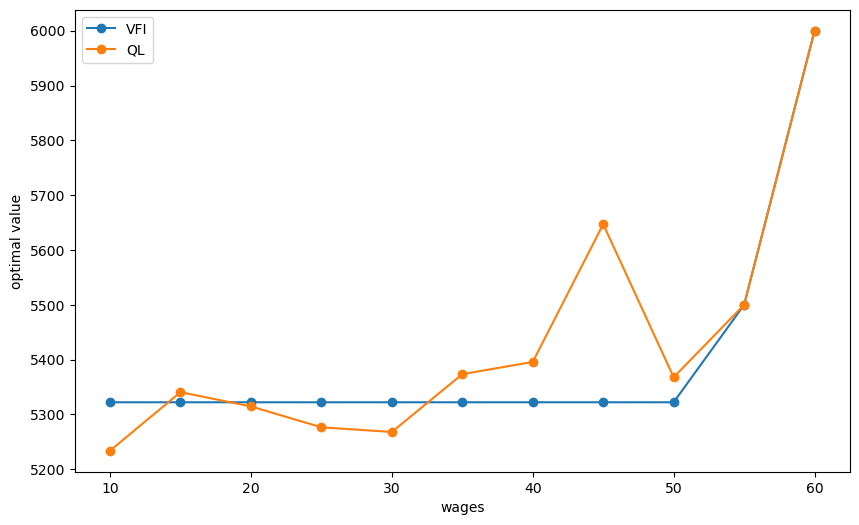

In [11]:
# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, valfunc_VFI, '-o', label='VFI')
ax.plot(w_default, valfunc_qlr, '-o', label='QL')
ax.set_xlabel('wages')
ax.set_ylabel('optimal value')
ax.legend()

plt.show()

Now, let us compute the case with a larger state space: $n=30$ instead of $n=10$.

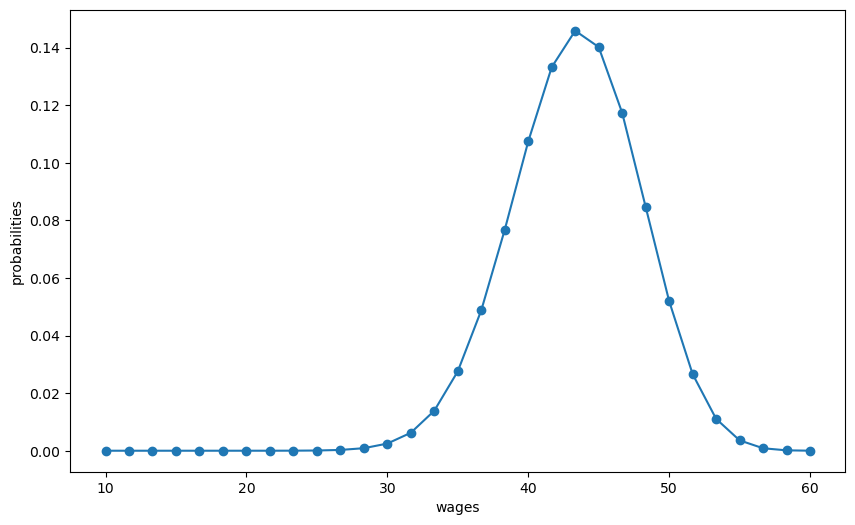

In [12]:
n, a, b = 30, 200, 100                        # default parameters
q_new = BetaBinomial(n, a, b).pdf()           # default choice of q

w_min, w_max = 10, 60
w_new = np.linspace(w_min, w_max, n+1)


# plot distribution of wage offer
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_new, q_new, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

# VFI
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()

In [13]:
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()
valfunc_VFI

array([4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       5000.        , 5166.66666667, 5333.33333333, 5500.        ,
       5666.66666667, 5833.33333333, 6000.        ])

In [14]:
def plot_epochs(epochs_to_plot, quit_allowed=1):
    "Plot value function implied by outcomes of an increasing number of epochs."
    qlmc_new = Qlearning_McCall(w=w_new, q=q_new, quit_allowed=quit_allowed)
    qtable = np.zeros((len(w_new),2))
    epochs_to_plot = np.asarray(epochs_to_plot)
    # plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(w_new, valfunc_VFI, '-o', label='VFI')

    max_epochs = np.max(epochs_to_plot)
    # iterate on epoch numbers
    for n in range(max_epochs + 1):
        if n%(max_epochs/10)==0:
            print(f"Progress: EPOCHs = {n}")
        if n in epochs_to_plot:
            valfunc_qlr = valfunc_from_qtable(qtable)
            error = compute_error(valfunc_qlr, valfunc_VFI)

            ax.plot(w_new, valfunc_qlr, '-o', label=f'QL:epochs={n}, mean error={error}')


        new_qtable = qlmc_new.run_one_epoch(qtable)
        qtable = new_qtable

    ax.set_xlabel('wages')
    ax.set_ylabel('optimal value')
    ax.legend(loc='lower right')
    plt.show()

Progress: EPOCHs = 0


Progress: EPOCHs = 20000


Progress: EPOCHs = 40000


Progress: EPOCHs = 60000


Progress: EPOCHs = 80000


Progress: EPOCHs = 100000


Progress: EPOCHs = 120000


Progress: EPOCHs = 140000


Progress: EPOCHs = 160000


Progress: EPOCHs = 180000


Progress: EPOCHs = 200000


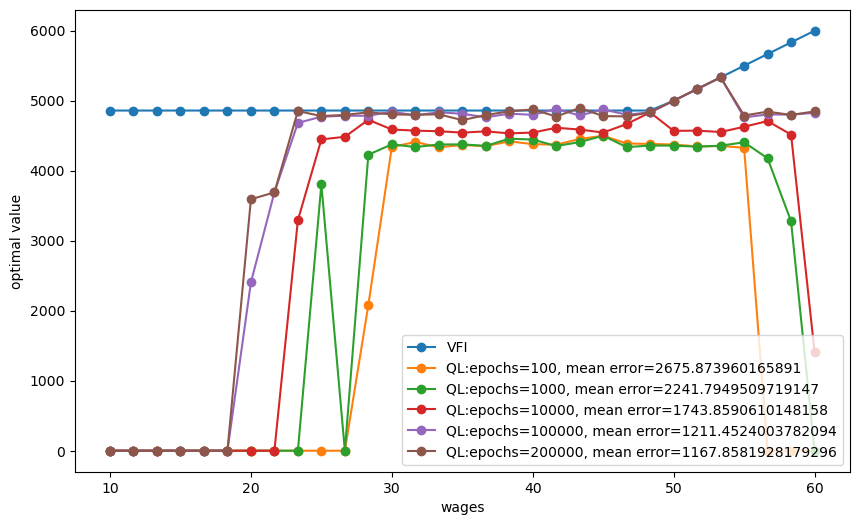

In [15]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000])

The above graphs indicates that

* the Q-learning algorithm has trouble  learning  the Q-table well for wages that are rarely drawn

* the quality of approximation to the "true" value function computed by value function iteration improves for longer epochs

## Employed Worker Can't Quit


The preceding version of temporal difference Q-learning described in  equation system  {eq}`eq:old4` lets an employed  worker quit, i.e., reject her wage as an incumbent and instead receive unemployment compensation this period
and draw a new offer next period.

This is an option that the McCall worker described in {doc}`this quantecon lecture <mccall_model>` would not take.

See {cite}`Ljungqvist2012`, chapter 6 on search, for a proof.

But in the context of Q-learning, giving the worker the option to quit and get unemployment compensation while
unemployed turns out to accelerate the learning process by promoting experimentation vis a vis premature
exploitation only.

To illustrate this, we'll amend our formulas for temporal differences to forbid an employed worker from quitting a job she had accepted earlier.

With this understanding about available choices, we obtain the following temporal difference values:

$$
\begin{aligned}
\widetilde{TD}\left(w,\text{accept}\right) & = \left[ w+\beta\widetilde{Q}^{old}\left(w,\text{accept}\right) \right]-\widetilde{Q}^{old}\left(w,\text{accept}\right) \\
\widetilde{TD}\left(w,\text{reject}\right) & = \left[ c+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{reject}\right),\;w'\sim F
\end{aligned}
$$ (eq:temp-diff)

It turns out that formulas {eq}`eq:temp-diff` combined with our Q-learning recursion {eq}`eq:old3` can lead our agent to eventually learn the optimal value function as well as in the case where an option to redraw can be exercised.

But learning is slower because  an agent who ends up accepting a wage offer prematurally loses the option to explore new states in the same episode and to adjust the value associated with that state.

This can lead to inferior outcomes when the number of epochs/episodes is low.

But if we increase the number of epochs/episodes, we can observe that the error decreases and the outcomes get better.


We illustrate these possibilities with the following code and graph.

Progress: EPOCHs = 0


Progress: EPOCHs = 20000


Progress: EPOCHs = 40000


Progress: EPOCHs = 60000


Progress: EPOCHs = 80000


Progress: EPOCHs = 100000


Progress: EPOCHs = 120000


Progress: EPOCHs = 140000


Progress: EPOCHs = 160000


Progress: EPOCHs = 180000


Progress: EPOCHs = 200000


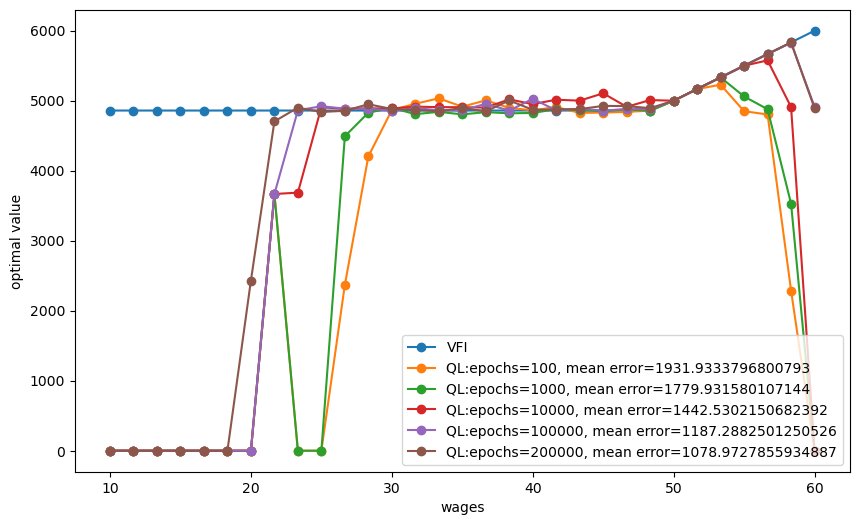

In [16]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000], quit_allowed=0)

## Possible Extensions

To extend the algorthm to handle problems with continuous state spaces,
a typical approach is to restrict Q-functions and policy functions to take particular
functional forms.

This is the approach in **deep Q-learning** where the idea is to use a multilayer neural
network as a good function approximator.

We will take up this topic in a subsequent quantecon lecture.